In [107]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [108]:
from src import Root
root = Root()
root.lib.jupyter_settings()

In [109]:
df = pd.read_csv("../data/housing_labeled.csv")

In [110]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,total_rooms_per_households,total_bedrooms_per_households,income_per_household,total_rooms_not_bedrooms,population_per_hosehold,income_per_population,total_rooms_not_bedrooms_per_households,distance_to_los_angeles,distance_to_san_francisco,distance_to_san_diego,distance_to_sacramento,distance_to_silicon_valley,distance_to_fresno,distance_to_santa_barbara,distance_to_san_jose,distance_to_oakland,distance_to_anaheim,distance_to_golden_gate_bridge,distance_to_yosemite_valley,distance_to_death_valley,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,is_high_value,target
0,-121.38,38.68,35.00,1565.00,290.00,861.00,277.00,2.48,5.65,1.05,0.01,1275.00,3.11,0.00,4.60,364.20,84.22,475.10,9.18,96.61,159.96,308.72,96.72,77.45,386.28,84.16,114.67,285.05,True,False,False,False,0.00,77000.00
1,-122.07,37.91,33.00,1550.00,277.00,638.00,254.00,3.68,6.10,1.09,0.01,1273.00,2.51,0.01,5.01,341.71,21.23,453.05,55.94,36.11,149.30,274.97,40.77,13.18,365.07,23.12,138.08,298.21,False,False,True,False,0.01,292500.00
2,-117.40,33.95,46.00,2189.00,423.00,866.00,389.00,3.14,5.63,1.09,0.01,1766.00,2.23,0.00,4.54,48.84,385.67,86.39,392.88,353.12,234.93,135.32,343.80,381.06,30.52,390.14,295.77,180.36,True,False,False,False,0.04,111500.00
3,-121.30,38.00,23.00,3706.00,1106.00,3785.00,1019.00,1.78,3.64,1.09,0.00,2600.00,3.71,0.00,2.55,321.77,62.99,433.12,41.54,59.21,120.44,262.91,55.85,54.64,344.38,65.43,96.46,260.65,True,False,False,False,0.00,100000.00
4,-118.32,33.33,52.00,2127.00,512.00,733.00,288.00,3.39,7.39,1.78,0.01,1615.00,2.55,0.00,5.61,50.09,383.86,79.43,403.88,350.57,249.65,109.23,342.14,380.55,42.08,388.29,320.72,234.79,False,True,False,False,0.01,300000.00


In [111]:
corr = df.corr()
corr["target"].sort_values(ascending = False) 

target                                     1.00
is_high_value                              0.60
median_income                              0.52
ocean_proximity_ISLAND                     0.42
distance_to_yosemite_valley                0.23
housing_median_age                         0.22
distance_to_sacramento                     0.17
total_rooms_not_bedrooms_per_households    0.15
distance_to_fresno                         0.15
total_rooms_per_households                 0.15
income_per_population                      0.10
distance_to_oakland                        0.10
ocean_proximity_NEAR BAY                   0.09
distance_to_golden_gate_bridge             0.09
distance_to_san_francisco                  0.09
distance_to_san_jose                       0.08
total_bedrooms_per_households              0.08
distance_to_silicon_valley                 0.08
ocean_proximity_NEAR OCEAN                 0.07
total_rooms_not_bedrooms                   0.06
total_rooms                             

In [112]:
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [ ]:
feature_names = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'total_rooms_per_households',
    'total_bedrooms_per_households',
    'income_per_household',
    'total_rooms_not_bedrooms',
    'population_per_hosehold',
    'income_per_population',
    'total_rooms_not_bedrooms_per_households',
    'distance_to_los_angeles',
    'distance_to_san_francisco',
    'distance_to_san_diego',
    'distance_to_sacramento',
    'distance_to_silicon_valley',
    'distance_to_fresno',
    'distance_to_santa_barbara',
    'distance_to_san_jose',
    'distance_to_oakland',
    'distance_to_anaheim',
    'distance_to_golden_gate_bridge',
    'distance_to_yosemite_valley',
    'distance_to_death_valley',
    'ocean_proximity_INLAND',
    'ocean_proximity_ISLAND',
    'ocean_proximity_NEAR BAY',
    'ocean_proximity_NEAR OCEAN',
    'is_high_value'
]

In [114]:
n_features = len(feature_names)
X = df[feature_names]
target = df["target"]


X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

metrics = {
    'fold': [],
    'rmse': [],
    'mae': [],
    'mape': [],
    'r2': []
}

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100,
    'random_state': 42,
    'eval_metric': 'rmse'
}

# Store feature importances across folds
feature_importances = np.zeros(n_features)

In [115]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):

    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_fold_train, y_fold_train)
    
    y_pred = model.predict(X_fold_val)
    
    rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
    mae = mean_absolute_error(y_fold_val, y_pred)
    mape = mean_absolute_percentage_error(y_fold_val, y_pred)
    r2 = r2_score(y_fold_val, y_pred)
    
    metrics['fold'].append(fold)
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['mape'].append(mape)
    metrics['r2'].append(r2)
    
    feature_importances += model.feature_importances_

In [116]:
feature_importances /= n_folds

final_model = xgb.XGBRegressor(**params)
final_model.fit(X_train, y_train)

y_test_pred = final_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTest set - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MAPE: {test_mape:.4f}%, R²: {test_r2:.4f}")


Test set - RMSE: 43194.0707, MAE: 27125.6748, MAPE: 15.0894%, R²: 0.8765


In [117]:
metrics_df = pd.DataFrame(metrics)
mean_metrics = {
    'fold': 'Mean',
    'rmse': metrics_df['rmse'].mean(),
    'mae': metrics_df['mae'].mean(),
    'mape': metrics_df['mape'].mean(),
    'r2': metrics_df['r2'].mean()
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([mean_metrics])], ignore_index=True)

metrics_df

,fold,rmse,mae,mape,r2
0,1,42197.70,27379.72,15.08,0.89
1,2,44117.22,28266.40,15.96,0.87
2,3,43938.05,28180.73,16.17,0.87
3,4,43828.84,28194.37,15.90,0.87
4,5,42644.79,27425.94,15.90,0.88
5,Mean,43345.32,27889.43,15.80,0.88



Feature Importances:
                                    Feature  Importance
22                   ocean_proximity_ISLAND        0.55
21                   ocean_proximity_INLAND        0.21
25                            is_high_value        0.10
6                             median_income        0.02
8             total_bedrooms_per_households        0.02
20                      distance_to_anaheim        0.01
11                  population_per_hosehold        0.01
14                  distance_to_los_angeles        0.01
17               distance_to_silicon_valley        0.01
10                 total_rooms_not_bedrooms        0.01
23                 ocean_proximity_NEAR BAY        0.01
19                      distance_to_oakland        0.00
3                               total_rooms        0.00
5                                households        0.00
13  total_rooms_not_bedrooms_per_households        0.00
15                distance_to_san_francisco        0.00
7                total_roo

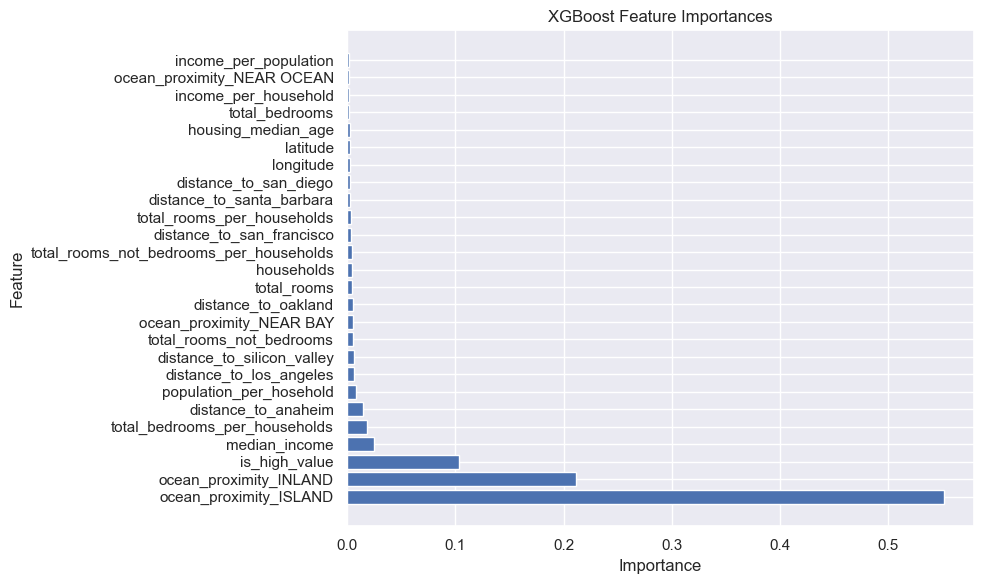

In [118]:

# Feature importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importances_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()